## Research Topic:
## Exploring Social Network and Bios of Active Users between Bluesky Communities

#### Melody Chang, Wendy Ding, Ayato Hisanaga

---

## Overview

Bluesky is a social platform where people from various backgrounds express themselves through bios, and connect with friends. In this project, we dive into Bluesky's world to analyze how users engage, connect, and express themselves. Using a step-by-step approach involving data collection, network analysis, and text sentiment examination, we aim to discover more about user behaviors, interests, and community dynamics, hoping to offer valuable insights into Bluesky's diverse community.


## Research questions:

Phase 1: Data Mining and Collection
- How many people use Bluesky?
- Who are the active users, and how do we recognize them?

Phase 2: Network Graph and Community Detection
- How can we visualize and interpret the social network graph of community connections?
- How do active users connect with each other on Bluesky?

Phase 3: Text and Sentiment Analysis
- How do users describe themselves in their bios?
- What sentiments do bios convey, and how do we measure them?
- What topics and interests are popular among active Bluesky users?



# Phase 1 Data Mining and Collection

## Step1  Extract all users from Bluesky

Q: Collecting all users from Bluesky for the analysis. How do we know how mamy users are there?

A: By collecting all the user dids, we realize there are 5343688 users on Bluesky

In [1]:
import requests
import json
from atproto import Client, models

The code below was used to extract every did on BlueSky:

In [ ]:
output_file_path = "/content/bsky_did_list.json"

out = []
cursor = 0
url = "https://bsky.network/xprc/com.atproto.sync.listRepos"
headers = {
    'Accept': 'application/json',
}

last_ind = 6000000

try:
    while int(cursor) <= last_ind:
        response = requests.request("GET", url, headers=headers, params={'limit':'10000','cursor':str(cursor)})
        curr_out = response.json()['repos']
        cursor = response.json()['cursor']
        out.extend(curr_out)
        print(f"current cursor: {cursor}")

except Exception as e:
    print(f"An error occurred: {e}")

# Write the content of 'out' list to the specified file
with open(output_file_path, "w") as outfile:
    json.dump(out, outfile)
print(f"Data saved to: {output_file_path}")

After initial extraction, we loaded the data directly:

In [9]:
with open('bsky_did_list.json') as f:
    bsky_did_list = json.load(f)
    
did_count = len(bsky_did_list)
print("Number of DIDs:", did_count)

Number of DIDs: 5343699


With over 5 million users, we use a sample of 210,000 random user DIDs.

In [19]:
# load the sample list
with open('bsky_sample_dids.json') as f:
    sample_dict = json.load(f)

sample_dict_count = len(sample_dict)
print("Number of user dicts:", sample_dict_count)

Number of user dicts: 210000


## Step.2 Filter out the active users

Q: Who are the active users?

A: The information we want to analyze should be a list of users who are active.

We identify "Active" means having at least 1 post.

We are also only interested in English-speaking communities.

The outputs are a json file and a csv file containing all users with English bios and their bio text.

In [21]:
client = Client()
client.login(username, password)

ProfileViewDetailed(did='did:plc:7g34khknkgm55ecz6n3kau6a', handle='yatobots.bsky.social', avatar='https://cdn.bsky.app/img/avatar/plain/did:plc:7g34khknkgm55ecz6n3kau6a/bafkreigv64exvqen3ssk5f4yaveteryphrvldli25lf5weqrksuyw5ub2m@jpeg', banner=None, description=None, display_name='', followers_count=9, follows_count=15, indexed_at='2024-01-26T04:01:57.918Z', labels=[], posts_count=3, viewer=ViewerState(blocked_by=False, blocking=None, blocking_by_list=None, followed_by=None, following=None, muted=False, muted_by_list=None, py_type='app.bsky.actor.defs#viewerState'), py_type='app.bsky.actor.defs#profileViewDetailed', associated={'lists': 0, 'feedgens': 0, 'labeler': False})

Because the data contains other key:value pairs, we extract the DIDs into a separate list:

In [22]:
key = 'did'
sample_dids = [d[key]for d in sample_dict]
sample_dids[:3]

['did:plc:fsc3wewcfxymsmwirdcrbfxg',
 'did:plc:6iio5gfd2iblzpce5fxz36ez',
 'did:plc:q7wms4nmbftjpbbrxa7j3sme']

We use this code to filter out DIDs with no profiles attached:

In [25]:
# filter out dids with no profiles attached
sample_dids_with_profiles = []
no_profile = 0

i = 0
for did in sample_dids:
    i += 1
    if i % 1000 == 0:
        print(i)
    try:
        user = client.get_profile(actor=did)
        if user:
            did = user.did
            sample_dids_with_profiles.append(did)
    except Exception as e: # all Exceptions are presumed to be a no-profile instance
        no_profile += 1

And we use this code to filter out users with 0 posts:

In [26]:
# filter out dids with 0 posts
sample_dids_with_posts = []
error_count = 0 # Should be 0 errors, but we leave in just in case

i = 0
for did in sample_dids_with_profiles:
    i += 1
    if i % 10 == 0:
        print(i)
    try:
        user = client.get_profile(actor=did)
        posts_count = user.posts_count
        if posts_count != 0:
            did = user.did
            sample_dids_with_posts.append(did)
    except Exception as e:
        error_count += 1
        continue

Afterwards, we load this in directly as well:

In [31]:
file_path = 'sample_dids_with_posts.json'
with open(file_path,"r") as file:
    sample_dids_with_posts = json.load(file)

We also filter for users who have a content in their bios, and extract it:

In [ ]:
# filter out dids with no bio
sample_dids_with_bios = []
i = 0
e_count = 0
for did in sample_dids_with_posts:
    i += 1
    if i % 100 == 0:
        print(i)
    try:
        profile = client.get_profile(did)
        did = profile['did']
        bio = profile['description']
        if bio:
            data = {
                'did':did,
                'bio':bio
            }
            sample_dids_with_bios.append(data)
    except Exception as e:
        e_count += 1

Load directly:

In [33]:
with open("sample_dids_with_bios.json") as file:
    dids_with_bios = json.load(file)

In order to filter the users using English, we use langdetect.

In [34]:
from langdetect import detect

In [ ]:
english_bios = []

e_count = 0
for profile in dids_with_bios:
    did = profile['did']
    bio = profile['bio']
    try:
        language = detect(bio)
        if language == 'en':
            user_lang = {
                'did':did,
                'bio':bio
            }
            english_bios.append(user_lang)
    except Exception as e:
        e_count += 1

Load directly:

In [35]:
english_bios = 'sample_dids_english_bios.json'
with open(english_bios, "r") as file:
    users = json.load(file)

Save the English bios into "english_bios.csv" for further analysis in phase 3

In [ ]:
df = pd.DataFrame(english_bios)
df.to_csv('english_bios.csv', index = False)

---

# Phase 2 Network Graph and Community Detection

Q: How does the active users network look like?

A:  We can graph the social network by using networkx to see how the active users connect with each other

In [36]:
import networkx as nx

In [37]:
users=users[:600]

In [39]:
bluesky_graph = nx.DiGraph()
for user in users:
    bluesky_graph.add_node(user['did'])
for user in users:
    did = user['did']
    cursor = None
    while True:
        followers = client.get_followers(did,cursor=cursor).model_dump()
        for follower in followers['followers']:
            if follower['did'] in bluesky_graph.nodes:
                bluesky_graph.add_edge(follower['did'],did)
        cursor = followers['cursor']
        if cursor:
            continue
        if not cursor:
            break
print(bluesky_graph)

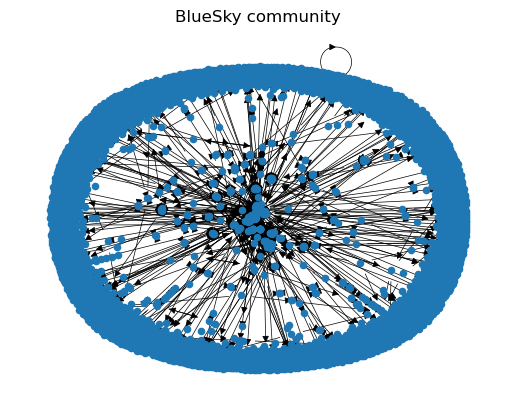

In [ ]:
import matplotlib.pyplot as plt
# Draw the graph
G=bluesky_graph
pos = nx.spring_layout(G)  # Positions for all nodes

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=20)

# Draw edges
nx.draw_networkx_edges(G, pos, width=0.5)

# Display the graph
plt.title("BlueSky community")
plt.axis("off")
plt.savefig('social graph_600.png')
plt.show()

In [ ]:
import pickle
pickle.dump(bluesky_graph, open('bluesky_graph.pickle', 'wb'))

In [ ]:
bluesky_graph = pickle.load(open('bluesky_graph.pickle','rb'))
print(bluesky_graph)

DiGraph with 4509 nodes and 1030 edges


### Community Detection

In [ ]:
!pip install community
# from community import community_louvain
import community as community_louvain
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [ ]:
# Convert list of dictionaries to a dictionary with "did" as keys and "bio" as values
users_dict = {user["did"]: user["bio"] for user in users}

In [ ]:
partition = nx.community.louvain_communities(bluesky_graph, seed=123)
partition_dict = {node: idx for idx, community in enumerate(partition) for node in community}

Let's take a look on communities. Most of them are isolated with a community size less than 10. We are interested in communities with a size larger than 50.

In [ ]:
def get_size(partition):
    return [len(cluster) for cluster in partition]


In [ ]:
com=[cluster for cluster in partition if len(cluster)>50]


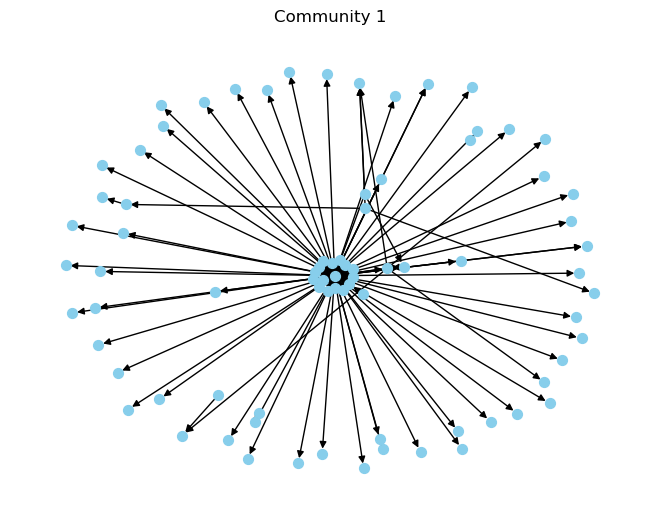

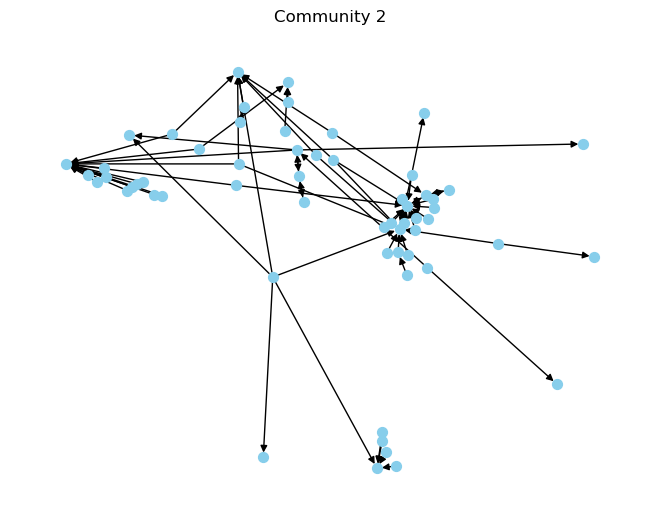

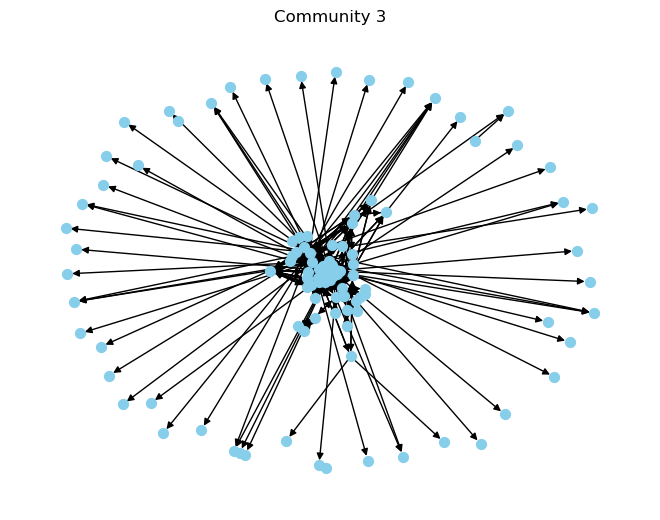

In [ ]:
for idx, community in enumerate(com):
    G=bluesky_graph
    subgraph = G.subgraph(community)
    plt.figure()
    nx.draw(subgraph, node_color='skyblue', node_size=50)
    plt.title(f"Community {idx + 1}")
    plt.savefig(f"graph{idx + 1}.png")
    plt.show()

In [ ]:
for idx, cluster in enumerate(com):
    # Specify the output CSV file path
    output_file = f"community_{idx + 1}.csv"
    cluster_bios=[entry for entry in users if entry['did'] in cluster]
    cluster_bios=pd.DataFrame(cluster_bios)
    cluster_bios.to_csv(output_file,index=False)

---

# Phase 3 Text and Sentimental Analysis

Q: How do active users usually introduce themselves? Anything specific?

A: Collecting the active users' bios, we could analyze the bios content and visualize them.

Q: How are the semtiments in the bios, what are the contents Polarity score and Subjectivity score?

A: We could distribute  the bio contents into categories and calculate the Polarity score and Subjectivity score to do sentimental analysis.

In [ ]:
!pip install nltk
! pip install wordcloud
import nltk, re, json, io
from collections import Counter

  Using cached nltk-3.8.1-py3-none-any.whl.metadata (2.8 kB)
  Using cached regex-2023.12.25-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (40 kB)
Using cached nltk-3.8.1-py3-none-any.whl (1.5 MB)
Using cached regex-2023.12.25-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (773 kB)
  Using cached wordcloud-1.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.4 kB)
Using cached wordcloud-1.9.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (511 kB)


In [ ]:
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

In [ ]:
df = pd.read_csv('english_bios.csv')
df.head()

,did,bio
0,did:plc:3idod7fmeivqb5zofco4se4a,He/him. Friend. Father figure. Comedian.
1,did:plc:3f4nflprttpnifxqca6dmut5,DEMOCRATIC RESISTANCE OF AMERICA (D.R.A.) Into...
2,did:plc:pnnukkwft5nxegfsxmc2sg6m,I'm a programmer who likes games. Developer fo...
3,did:plc:ihvtbs5grfulec6yt6jxua37,An account for stuff. Idk. She/Her. Village Id...
4,did:plc:ygnkamsogabezg5hsaruolic,Just a lurker doing what lurkers do lurking ar...


## Step 1 Word Cleaning

Use stopeng to remove stop words and exclamation marks from the bios in the three communities that have more than 5000 users.
Names as community 1, 2, 3

In [ ]:
import pandas as pd

In [ ]:
df1=pd.read_csv('community_1.csv')

In [ ]:
df2=pd.read_csv('community_2.csv')

In [ ]:
df3=pd.read_csv('community_3.csv')

In [ ]:
# Join all bios into a single string
bio1 = ' '.join(df1['bio'])
# Tokenize the bio into words
bio_words1 = word_tokenize(bio1.lower())

# Join all bios into a single string
bio2 = ' '.join(df2['bio'])
# Tokenize the bio into words
bio_words2 = word_tokenize(bio2.lower())

# Join all bios into a single string
bio3 = ' '.join(df3['bio'])
# Tokenize the bio into words
bio_words3 = word_tokenize(bio3.lower())

In [ ]:
# word cleaning

stopeng=set(stopwords.words('english'))

def textcleaner(row):
    row = row.lower()
    #remove urls
    row  = re.sub(r'http\S+', '', row)
    #remove mentions
    row = re.sub(r"(?<![@\w])@(\w{1,25})", '', row)
    #remove hashtags
    row = re.sub(r"(?<![#\w])#(\w{1,25})", '',row)
    #remove other special characters
    row = re.sub('[^A-Za-z .-]+', '', row)
    #remove digits
    row = re.sub('\d+', '', row)
    row = row.strip(" ")
    row = re.sub('\s+', ' ', row)
    row = ' '.join([word for word in row.split() if word not in stopeng])
    return row


In [ ]:
cleaned_bio_words1 = []
for t in bio_words1:
    cleaned_text = textcleaner(t)
    # Check if the cleaned text is not an empty string or just a period
    if cleaned_text != '' and cleaned_text != '.' and cleaned_text != ':' and cleaned_text != '-' and cleaned_text != 'x' and cleaned_text != 'X' and cleaned_text != 'http':
        cleaned_bio_words1.append(cleaned_text)


In [ ]:
cleaned_bio_words2 = []
for t in bio_words2:
    cleaned_text = textcleaner(t)
    # Check if the cleaned text is not an empty string or just a period
    if cleaned_text != '' and cleaned_text != '.' and cleaned_text != ':' and cleaned_text != 'l' and cleaned_text != 'x' and cleaned_text != 'X' and cleaned_text != 'http':
        cleaned_bio_words2.append(cleaned_text)


In [ ]:
cleaned_bio_words3 = []
for t in bio_words3:
    cleaned_text = textcleaner(t)
    # Check if the cleaned text is not an empty string or just a period
    if cleaned_text != '' and cleaned_text != '.' and cleaned_text != ':' and cleaned_text != '-' and cleaned_text != 'x' and cleaned_text != 'X' and cleaned_text != 'http':
        cleaned_bio_words3.append(cleaned_text)


In [ ]:
cleaned_bio_words1[:5]

['sheher', 'eternally', 'late', 'party', 'regulr']

In [ ]:
cleaned_bio_words2[:5]

['welcome', 'follow', 'collaborate', 'facebook', 'pixiv']

In [ ]:
cleaned_bio_words3[:5]

['walking', 'tightrope', 'wilderness', 'ambivalence', 'hehim']

## Step 2 Create Word Cloud

In order to have a broader view on the bios, we draw a wordcloud to display the contents from the bios for community 1,2,3
Then, we calculate the top 10 most frequent words that appear in the bios and compare between communities.

### Community 1

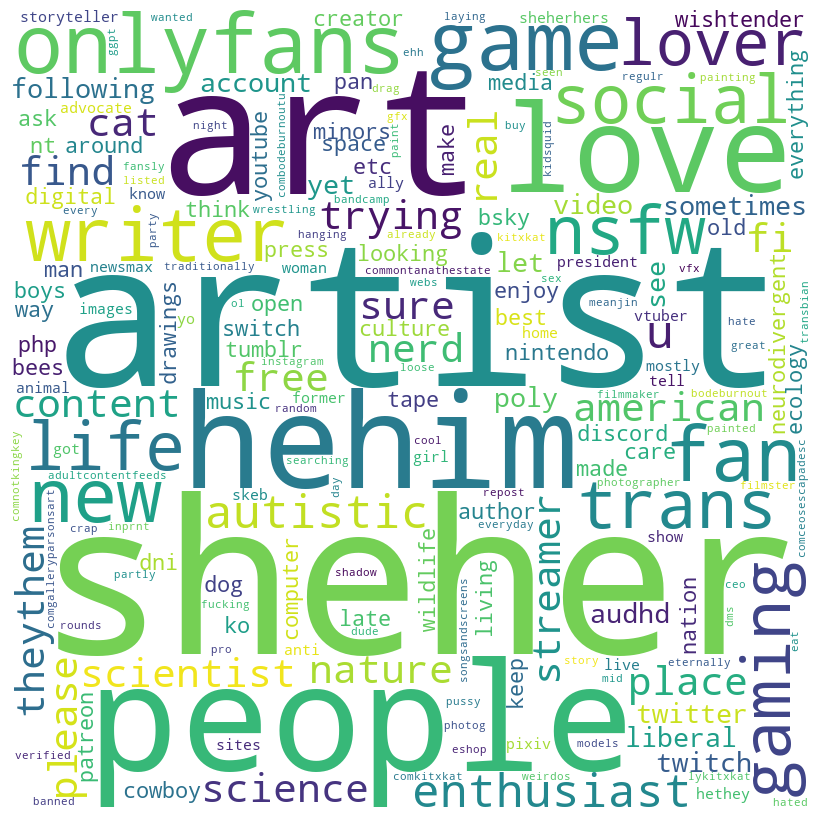

In [ ]:
# Generate the word cloud
wordcloud_comments1 = WordCloud(width=800, height=800,
                               background_color='white',
                               min_font_size=10).generate(' '.join(cleaned_bio_words1))

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud_comments1)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('c1.png')
# Show the plot
plt.show()


In [ ]:
# Count the frequency of each word
word_counts1 = Counter(cleaned_bio_words1)

# Print the top ten most common words
print("Top Ten Most Common Words in bios -Coummunity1")
for word, count in word_counts1.most_common(10):
    print(f"{word}: {count}")

Top Ten Most Common Words in bios -Coummunity1
sheher: 10
artist: 7
people: 7
hehim: 7
art: 6
writer: 5
games: 5
nsfw: 4
love: 4
life: 4


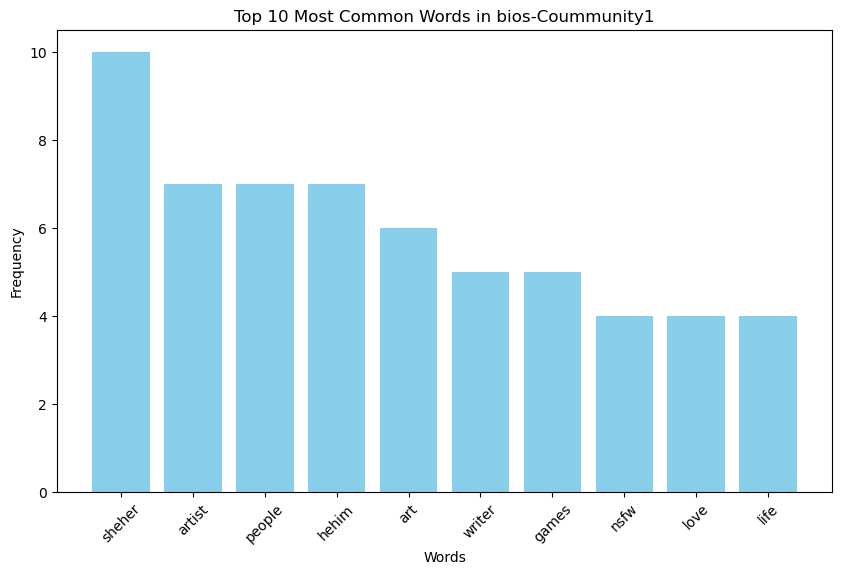

In [ ]:

# Extract top ten most common words and their counts
top_ten_words1 = [word[0] for word in word_counts1.most_common(10)]
top_ten_counts1 = [word[1] for word in word_counts1.most_common(10)]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(top_ten_words1, top_ten_counts1, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words in bios-Coummunity1')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.savefig('word1.png')
plt.show()


### Findings for Community 1:

Based on the Top 10 Most Common Words in bios chart for Community 1, it's evident that active users  in the community are anime lovers who likes vtuber and Japan culture. We can see words such as "like" , "love", "vtuber", "japan", "fan"

Note: VTuber (Japanese: ブイチューバー) or virtual YouTuber is an online entertainer who uses a virtual avatar generated using computer graphics. Real-time motion capture software or technology are often—but not always—used to capture movement. The digital trend originated in Japan in the mid-2010s, and has become an international online phenomenon in the 2020s.

Source: Wikipedia https://en.wikipedia.org/wiki/VTuber

### Coummunity 2

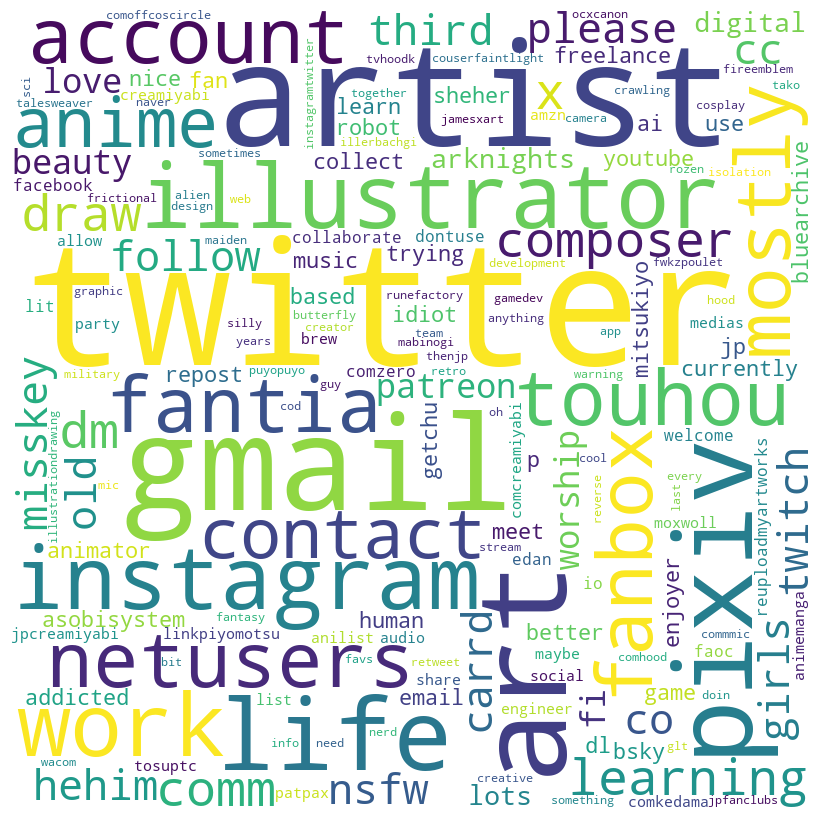

In [ ]:
# Generate the word cloud
wordcloud_comments2 = WordCloud(width=800, height=800,
                               background_color='white',
                               min_font_size=10).generate(' '.join(cleaned_bio_words2))

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud_comments2)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('c2.png')
# Show the plot
plt.show()

In [ ]:
# Count the frequency of each word
word_counts2 = Counter(cleaned_bio_words2)

# Print the top ten most common words
print("Top Ten Most Common Words in bios- Coummunity2")
for word, count in word_counts2.most_common(10):
    print(f"{word}: {count}")

Top Ten Most Common Words in bios- Coummunity2
artist: 10
twitter: 9
gmail.com: 9
art: 8
like: 7
life: 5
illustrator: 4
pixiv: 3
www.pixiv.netusers: 3
touhou: 3


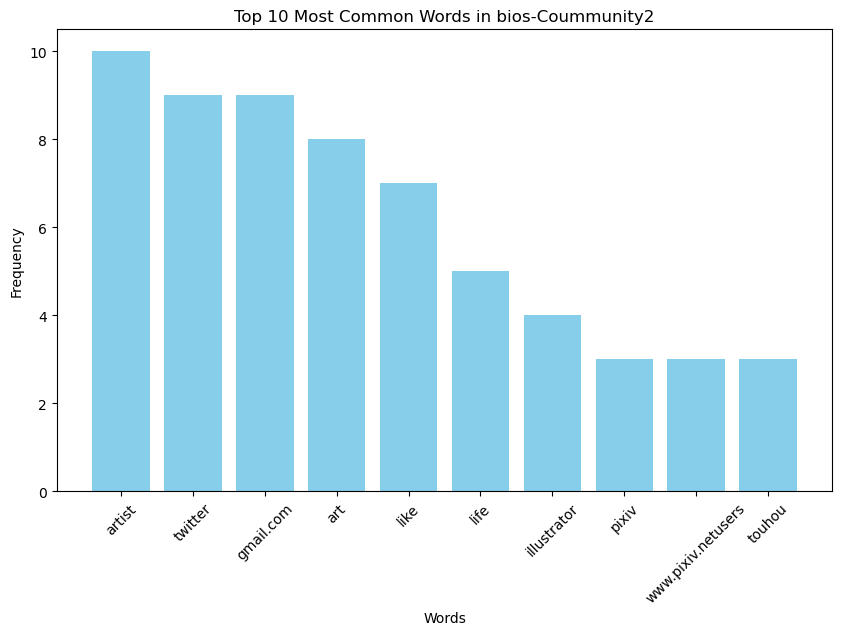

In [ ]:
# Extract top ten most common words and their counts
top_ten_words2 = [word[0] for word in word_counts2.most_common(10)]
top_ten_counts2 = [word[1] for word in word_counts2.most_common(10)]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(top_ten_words2, top_ten_counts2, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words in bios-Coummunity2')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.savefig('w2.png')
plt.show()

### Findings for Community 2:

Based on the Top 10 Most Common Words in bios chart for Community 2, it's evident that active users  in the community often add their twitter account to Bluesky bio. It seems that this community might be more fragment compared to the others because that does have similar words in their bios.

### Community 3

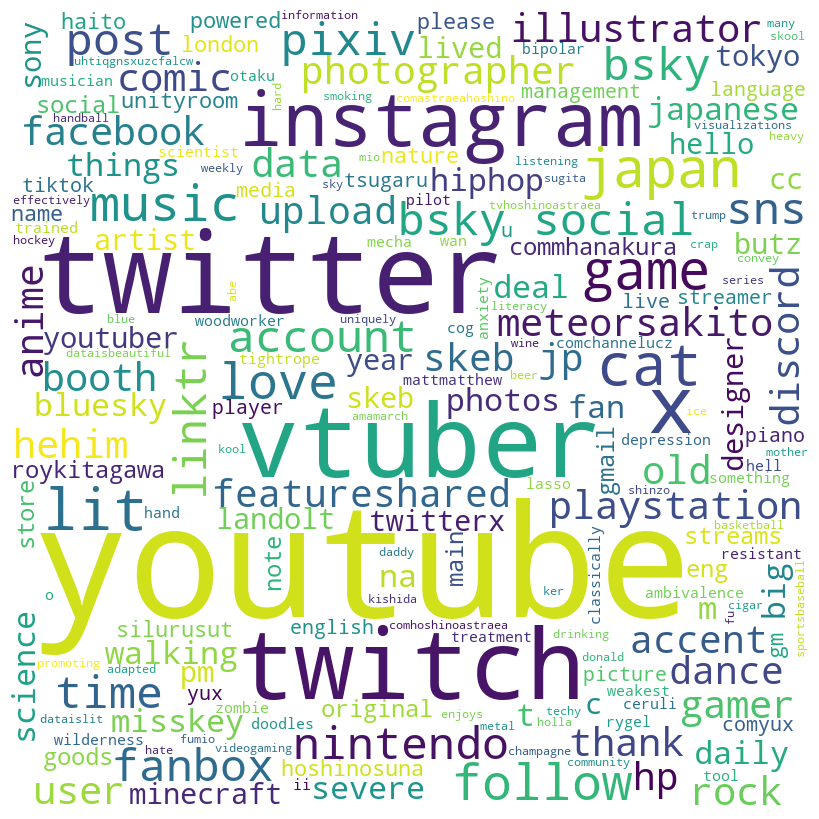

In [ ]:
# Generate the word cloud
wordcloud_comments3 = WordCloud(width=800, height=800,
                               background_color='white',
                               min_font_size=10).generate(' '.join(cleaned_bio_words3))

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud_comments3)
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('c3.png')
# Show the plot
plt.show()

In [ ]:
# Count the frequency of each word
word_counts3 = Counter(cleaned_bio_words3)

# Print the top ten most common words
print("Top Ten Most Common Words in bios-Coummunity3")
for word, count in word_counts3.most_common(10):
    print(f"{word}: {count}")

Top Ten Most Common Words in bios-Coummunity3
youtube: 33
vtuber: 24
youtube.com: 17
twitter: 16
twitch: 11
www.youtube.com: 11
instagram: 6
like: 6
japan: 6
music: 5


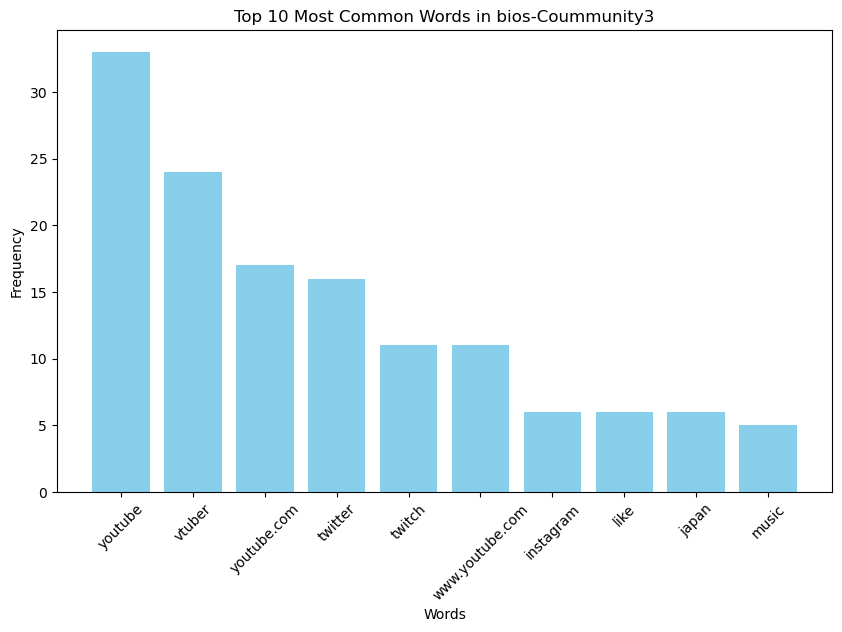

In [ ]:
# Extract top ten most common words and their counts
top_ten_words3 = [word[0] for word in word_counts3.most_common(10)]
top_ten_counts3 = [word[1] for word in word_counts3.most_common(10)]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(top_ten_words3, top_ten_counts3, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Common Words in bios-Coummunity3')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.savefig('w3.png')
plt.show()

### Findings for Community 3:

Based on the Top 10 Most Common Words in bios chart for Community 3, it's evident that active users often include pronouns like "she/her" or "he/him" to describe themselves. They also tend to share their interests, using verbs like "love" and "like" and nouns such as "games" and "art" to express their hobbies. Additionally, it's common for users to mention their occupations, with "artist" and "writer" being popular choices among amateurs on Bluesky.

## Step 3 Identify the sentiments

We use TextBolb to identify the polarity and Subjectivity score for bios in Community 1, 2, 3

In [ ]:
!pip install TextBlob

In [ ]:
from textblob import TextBlob
# Community 1

blob = TextBlob(bio1)
polarity = blob.polarity

if polarity < -0.5:
    sentiment = "highly negative"
elif polarity >= -0.5 and polarity < 0:
    sentiment = "negative"
elif polarity == 0:
    sentiment = "neutral"
elif polarity > 0 and polarity <= 0.5:
    sentiment = "positive"
else:
    sentiment = "highly positive"

print("Polarity score for bios:", polarity)
print("Sentiment:", sentiment)


subjectivity = blob.subjectivity

if subjectivity <= 0.2:
    text_type = "very objective"
elif subjectivity > 0.2 and subjectivity <= 0.4:
    text_type = "objective"
elif subjectivity > 0.4 and subjectivity <= 0.6:
    text_type = "neutral"
elif subjectivity > 0.6 and subjectivity <= 0.8:
    text_type = "subjective"
else:
    text_type = "very subjective"

print("Subjectivity score for bios:", subjectivity)
print("Text type:", text_type)

Polarity score for bios: 0.08150126139322916
Sentiment: positive
Subjectivity score for bios: 0.5364583333333333
Text type: neutral


In [ ]:
# Coummunity 2

blob = TextBlob(bio2)
polarity = blob.polarity

if polarity < -0.5:
    sentiment = "highly negative"
elif polarity >= -0.5 and polarity < 0:
    sentiment = "negative"
elif polarity == 0:
    sentiment = "neutral"
elif polarity > 0 and polarity <= 0.5:
    sentiment = "positive"
else:
    sentiment = "highly positive"

print("Polarity score for bios:", polarity)
print("Sentiment:", sentiment)


subjectivity = blob.subjectivity

if subjectivity <= 0.2:
    text_type = "very objective"
elif subjectivity > 0.2 and subjectivity <= 0.4:
    text_type = "objective"
elif subjectivity > 0.4 and subjectivity <= 0.6:
    text_type = "neutral"
elif subjectivity > 0.6 and subjectivity <= 0.8:
    text_type = "subjective"
else:
    text_type = "very subjective"

print("Subjectivity score for bios:", subjectivity)
print("Text type:", text_type)

Polarity score for bios: 0.3472222222222222
Sentiment: positive
Subjectivity score for bios: 0.5185185185185186
Text type: neutral


In [ ]:
# Community 3
blob = TextBlob(bio3)
polarity = blob.polarity

if polarity < -0.5:
    sentiment = "highly negative"
elif polarity >= -0.5 and polarity < 0:
    sentiment = "negative"
elif polarity == 0:
    sentiment = "neutral"
elif polarity > 0 and polarity <= 0.5:
    sentiment = "positive"
else:
    sentiment = "highly positive"

print("Polarity score for bios:", polarity)
print("Sentiment:", sentiment)


subjectivity = blob.subjectivity

if subjectivity <= 0.2:
    text_type = "very objective"
elif subjectivity > 0.2 and subjectivity <= 0.4:
    text_type = "objective"
elif subjectivity > 0.4 and subjectivity <= 0.6:
    text_type = "neutral"
elif subjectivity > 0.6 and subjectivity <= 0.8:
    text_type = "subjective"
else:
    text_type = "very subjective"

print("Subjectivity score for bios:", subjectivity)
print("Text type:", text_type)

Polarity score for bios: 0.10021208955863956
Sentiment: positive
Subjectivity score for bios: 0.48768266850705055
Text type: neutral


### Findings:

From the Polarity score for bios, we can find that the sentiment on bios is positive in the three communities.
On the other hand, the subjectivity score for bios is neutral. We think the results aligns to our expectations since the bios are usually how people describe themselve to others, so it shouldn;t have much negative emotions or extreme subjective or  objective wording included.

---

## Conclusion

Social media platforms serve as an important digital space where people of all backgrounds can connect and create online communities. BlueSky is a relatively new platform that provides a unique opportunity to identify communities organized around certain topics and themes. In Phase 1, data mining and collection was performed using BlueSky's API, resulting in a list of all user IDs. In Phase 2, a network graph was constructed along with a list of communities.

In this phase, textual analysis was applied in communities with over 5,000 users to assess topics of interest, general sentiment, and subjectivity. Our sample contained three communities, and our analysis reveals that each community has distinct themes.

## Limitations and Future Work

Our project has shown that communities can be identified on BlueSky, and we now possess data on the topics, themes, and general sentiment of sample communities. This data could serve as an important starting point to track changes within communities over time. As BlueSky coninues to grow, understanding changes in user sentiment or themes could provide valuable insights into the nature of communities. Future work should expand the sample size by including non-English-speaking users to distinguish more communities and respective topics. Topic Modeling methods could also be used to identify topics as well.